# Decomposing soverign bond spreads

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The complete codebase for this project is available at [**`github.com/janjdarecki/instquality`**](https://github.com/janjdarecki/instquality)

### Summary

This analysis investigates the relationship between institutional‑quality and macroeconomic fundamentals and sovereign bond spreads through three complementary exercises.

First, the baseline incremental‑signal analysis tests whether fundamentals provide forecasting power for next‑year spreads beyond simple mean reversion. Regularised regressions (Lasso, Ridge, Elastic Net) are benchmarked against an autoregressive model. The results show that sovereign spreads are highly persistent and that fundamentals add only marginal short‑term predictive content — suggesting that most macro‑institutional information is already priced into current spreads.

Second, the priced‑in levels analysis examines how much of the current cross‑sectional variation in spreads can be structurally explained by fundamentals themselves. Around half of the dispersion is accounted for by institutional and macro variables, indicating that structural characteristics — such as governance quality, monetary credibility, and openness — are deeply embedded in sovereign risk premia.

Finally, the temporal incremental‑signal analysis extends the forecast horizon to 1–10 years to assess how the informational value of fundamentals evolves over time. Short horizons remain dominated by persistence, but meaningful signal appears at medium‑to‑long horizons (roughly 4–10 years), where macro‑institutional variables begin to add incremental predictive power. Together, the three analyses show that spreads price structural fundamentals heavily in levels, react little to them in the short term, and only gradually re‑express their influence over longer horizons.

### Introducing the data

The dataset combines institutional‑quality and macroeconomic indicators from seven major international sources, covering 1960–2023.  It brings together political, governance, and market‑freedom variables used as predictors of sovereign bond spreads.  

A detailed overview of data coverage, quartile values, distributions, and pairwise correlations is available in the **`01_load_and_visualise`** notebook.  Data preparation, including handling of missing values, removal of sparsely populated columns, and engineering of lagged and averaged variables, was performed in **`02_preprocess`**. For a full list of variables please refer to the **`functions/labels`** file.

| Source | Description | Period | Variables | Example Variables |
|---------|--------------|---------|------------|------------------|
| **EFW** | *Economic Freedom of the World* — Fraser Institute | 1970–2021 | 79 | Judicial Independence, Freedom of Foreigners to Visit, Military Interference, Private Sector Credit, Monetary Freedom |
| **FIW** | *Freedom in the World* — Freedom House | 2006–2023 | 16 | Political Rights, Civil Liberties, Electoral Process, Rule of Law, Freedom of Expression |
| **IEF** | *Index of Economic Freedom* — Heritage Foundation | 1995–2023 | 13 | Property Rights, Government Integrity, Fiscal Health, Trade Freedom, Investment Freedom |
| **P5D** | *Polity V Dataset* — Polity Project | 1960–2020 | 17 | Democracy Score, Autocracy Score, Executive Constraints, Competitiveness of Participation, Regime Durability |
| **PTS** | *Political Terror Scale* | 1976–2022 | 6 | Political Terror Scale (Amnesty International, Human Rights Watch, State Department) |
| **WGI** | *World Governance Indicators* — World Bank | 1996–2022 | 36 | Voice & Accountability, Government Effectiveness, Regulatory Quality, Rule of Law, Control of Corruption |
| **WB** | *World Bank (macro + institutional)* | 1960–2023 | 46 | GDP Growth, Inflation (CPI), Current Account Balance, Central Government Debt, Statistical Capacity Index, Social Progress Index |

---
*10‑Year Sovereign Spread over U.S. Treasuries (%)* was constructed from OECD and World Bank bond yields (1960–2024) and serves as the unified dependent variable across all analyses, representing long‑term sovereign borrowing costs relative to a global risk‑free benchmark.  More information on the target variable, including its construction, coverage, and descriptive statistics, can be found in the **`01_load_and_visualise`** notebook.

### Methods

The analysis uses a unified framework for regularised regression, implemented in **`functions/specs`** to estimate and interpret the relationship between institutional‑quality, macroeconomic variables, and sovereign bond spreads. The framework supports three model types — Lasso, Ridge, and Elastic Net — implemented with expanding‑window cross‑validation for time‑series consistency. The procedure automatically selects optimal regularisation parameters and can be applied in either an agnostic (unrestricted coefficients) or β=1 specification, the latter interpreting coefficients relative to mean‑reversion benchmarks. The analyses are executed in the **`03_run_base_analysis`** and **`04_run_temporal_analysis`** notebooks.

Feature preparation includes imputation, scaling, clustering, and correlation diagnostics. Highly correlated variable variants are grouped via hierarchical clustering (using a configurable correlation threshold), and only representative variables are retained to reduce redundancy. This ensures interpretability while allowing the model to capture cross‑sectional heterogeneity. Additional checks identify cross‑variable correlations above the threshold, primarily for transparency since regularisation already addresses multicollinearity.

To enhance interpretability, the framework integrates feature‑attribution and stability analysis. SHAP values quantify each variable’s contribution to predicted spreads, while stability selection evaluates how consistently each feature is chosen across repeated subsamples. Both are aggregated by core variable — merging lagged, differenced, and moving‑average variants into unified economic indicators. Model performance is evaluated using R², RMSE, and Diebold‑Mariano tests to assess whether fundamentals provide statistically significant incremental predictive power beyond mean reversion.

## Results

### Baseline incremental signal

This section asks whether institutional‑quality and macroeconomic fundamentals contain incremental forecasting power for next‑year sovereign spreads beyond simple mean reversion.

We first estimate an autoregressive benchmark model (t → t+1) to capture the persistence of spreads, then compare its out‑of‑sample accuracy with regularised regressions (Ridge, Lasso, Elastic Net) using macroeconmic and institutional quality (IQ) fundamentals as predictors.

Model performance is evaluated via R², RMSE, and Diebold‑Mariano tests for equal predictive accuracy.

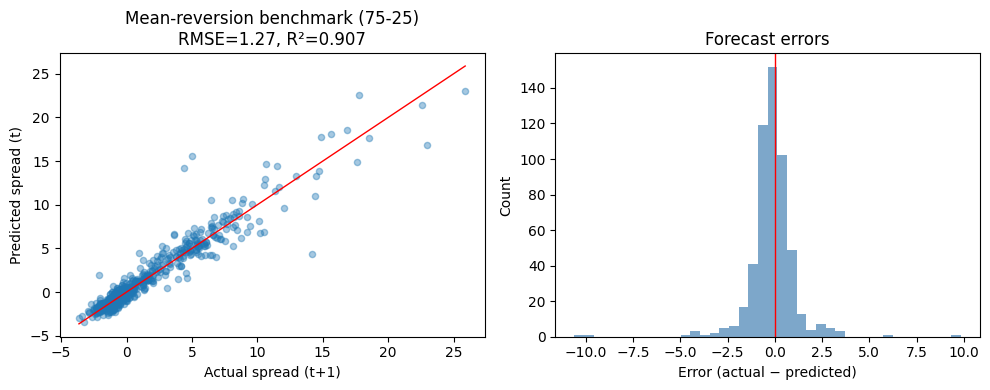

Share of between-country variance in total variance: 90.72%


In [2]:
# mean-reversion as benchmark

import pandas as pd

df = pd.read_pickle("saved/df.dat")

from functions.summary import show_simple_benchmark

show_simple_benchmark(df, 0.75)
# show_simple_benchmark(df, 0.8)
# show_simple_benchmark(df, 0.85)

Mean-reversion benchmark results:

- 75–25 split: RMSE = 1.27, R² = 0.907, Share of between-country variance in total variance = 90.72%

- 80–20 split: RMSE = 1.22, R² = 0.908, Share = 91.36%

- 85–15 split: RMSE = 1.32, R² = 0.894, Share = 92.98%

Across all data splits, close to 90% of the variation in next‑year sovereign spreads is explained simply by the current spread. This highlights a very strong degree of persistence, consistent with the idea that sovereign credit premia adjust slowly over time. On average, the benchmark misses by roughly 1.2–1.3 percentage points (120–130 bps).

The stability of R² across multiple train–test splits confirms that this persistence is not an artefact of sample composition. The share of between‑country variance above 90% further indicates that much of the dispersion in spreads reflects structural cross‑country differences rather than time‑varying shocks.

This benchmark provides the starting point for the incremental signal analysis below, which tests whether institutional‑quality and macroeconomic variables can explain the unexpected component of next year's spread beyond what is captured by mean reversion. The subsequent section then examines how much of today’s spread level can be structurally explained by fundamentals repesented by macro and institutional quality variables (“priced‑in levels”).

In [3]:
from functions.summary import get_benchmark_stats, summarise_signal_regressions

import pandas as pd

df = pd.read_pickle("saved/df.dat")

benchmark_df_75 = get_benchmark_stats(df, 0.75)
benchmark_df_80 = get_benchmark_stats(df, 0.80)
benchmark_df_85 = get_benchmark_stats(df, 0.85)

benchmark_dfs = {
    0.75: benchmark_df_75,
    0.80: benchmark_df_80,
    0.85: benchmark_df_85
}

summarise_signal_regressions(
    "specs",
    base_name="signal",
    models=["ridge", "lasso", "elastic"],
    benchmark_dfs=benchmark_dfs
)

INCREMENTAL SIGNAL REGRESSIONS — PERFORMANCE SUMMARY (75-25 split)
Benchmark R²: 0.9074, Benchmark RMSE: 1.2728
                Model R²_test RMSE_test ΔR² vs Benchmark (p.p.) ΔRMSE vs Benchmark (bps) H1=Incremental signal present DM_stat  DM_p
                Ridge  0.9085    1.2651                   +0.11                     -0.8                      Rejected    1.03 0.303
                Lasso  0.9090    1.2619                   +0.16                     -1.1                      Rejected    1.00 0.319
Elastic Net (L1=0.75)  0.9087    1.2642                   +0.12                     -0.9                      Rejected    1.00 0.316
 Elastic Net (L1=0.5)  0.9086    1.2645                   +0.12                     -0.8                      Rejected    1.08 0.281
Elastic Net (L1=0.25)  0.9086    1.2649                   +0.12                     -0.8                      Rejected    1.08 0.281

INCREMENTAL SIGNAL REGRESSIONS — PERFORMANCE SUMMARY (80-20 split)
Benchmark R²: 0.9075, 

The incremental‑signal exercise evaluates whether institutional quality (IQ) and macroeconomic variables contain predictive power for next‑year sovereign spreads beyond the mean‑reversion benchmark. Performance is benchmarked against the autoregressive baseline (R² approx 0.90), RMSE ≈ 1.2–1.3 p.p.).

Overall, the regularised models reproduce the benchmark’s accuracy almost exactly, but do not deliver statistically meaningful out‑of‑sample gains. This suggests that most of the information embedded in institutional and macro variables is already reflected in the current spread, reinforcing the strong persistence pattern documented earlier.

These findings set up the next section, which investigates the cross‑sectional (priced‑in level) determinants of spreads — assessing how much of the level of spreads can be structurally explained by fundamentals, even if they do not predict reversion dynamics.

### Priced-in levels (cross-sectional fundamentals)

Here we explore how much of the current level of sovereign spreads can be structurally explained by macroeconomic and institutional fundamentals.

Unlike the forecasting setup, these regressions are cross‑sectional: spreads and fundamentals are measured contemporaneously. We estimate regularised models (Ridge, Lasso, Elastic Net) and assess out‑of‑sample explanatory power (R², RMSE). SHAP importance values decompose which variables or categories contribute most to the priced‑in structure.

In [4]:
from functions.labels import all_labels
from functions.summary import summarise_priced_in_regressions

model_configs = [
    ("lasso", None),
    ("ridge", None),
    ("elastic", 0.25),
    ("elastic", 0.5),
    ("elastic", 0.75)
]

summarise_priced_in_regressions(
    specs_dir="specs",
    base_name="levels",
    suffix="",
    model_configs=model_configs,
    all_labels=all_labels,
    h=0
)

PRICED‑IN LEVEL REGRESSIONS — PERFORMANCE SUMMARY
 Horizon Split                 Model  R²_train  R²_test  RMSE_test
       0 75‑25 Elastic Net (L1=0.25)    0.8492   0.5086     2.9377
       0 75‑25  Elastic Net (L1=0.5)    0.8203   0.5097     2.9342
       0 75‑25 Elastic Net (L1=0.75)    0.8002   0.5175     2.9110
       0 75‑25                 Lasso    0.7904   0.5146     2.9197
       0 75‑25                 Ridge    0.7440   0.5549     2.7959
       0 80‑20 Elastic Net (L1=0.25)    0.8956   0.6021     2.5346
       0 80‑20  Elastic Net (L1=0.5)    0.8793   0.6116     2.5042
       0 80‑20 Elastic Net (L1=0.75)    0.8638   0.6030     2.5315
       0 80‑20                 Lasso    0.8828   0.6127     2.5007
       0 80‑20                 Ridge    0.8685   0.6231     2.4667
       0 85‑15 Elastic Net (L1=0.25)    0.8918   0.6327     2.4706
       0 85‑15  Elastic Net (L1=0.5)    0.8755   0.6389     2.4495
       0 85‑15 Elastic Net (L1=0.75)    0.8600   0.6289     2.4831
       0 85‑

The priced‑in level regressions test how far today’s sovereign spread levels can be explained by structural fundamentals. Across models and data splits, institutional and macroeconomic variables jointly account for about 50–63% of the cross‑sectional variance in spreads, with stable out‑of‑sample R² values around 0.5–0.6 and RMSE near 2.5–2.9 percentage points. Performance improves modestly with larger training samples, confirming the robustness of the underlying relationships.

Institutional quality variables play a key role in shaping the permanent component of sovereign risk. Indicators of monetary and legal integrity — such as Monetary Freedom, Judicial Independence, and Integrity of the Legal System — emerge as the most systematically selected features. Measures of state capacity and governance (e.g., Impartial Public Administration, Transfers and Subsidies, Military Interference) further contribute to explaining long‑run differences in perceived sovereign credibility.

Macroeconomic fundamentals complement this institutional structure. External balances, inflation stability, real growth, and credit depth all show consistent importance across models, suggesting that both macro discipline and structural openness are priced dimensions of sovereign spreads. Together, these results imply that while short‑term changes in spreads are largely unpredictable, cross‑country differences reflect persistent macro‑institutional foundations that markets incorporate into risk premia.

### Temporal incremental signal

This section examines whether institutional‑quality and macroeconomic variables provide incremental predictive signal for sovereign spreads over longer forecast horizons (1–10 years) and how this signal evolves with time.

We re‑estimate the mean‑reversion benchmark and regularised models at each horizon to assess whether fundamentals' predictive relevance as persistence decays. Model performance is compared across horizons using out‑of‑sample R², RMSE, and Diebold‑Mariano tests, which classify each horizon as dominated by signal, noise, or equal predictive accuracy relative to the benchmark.

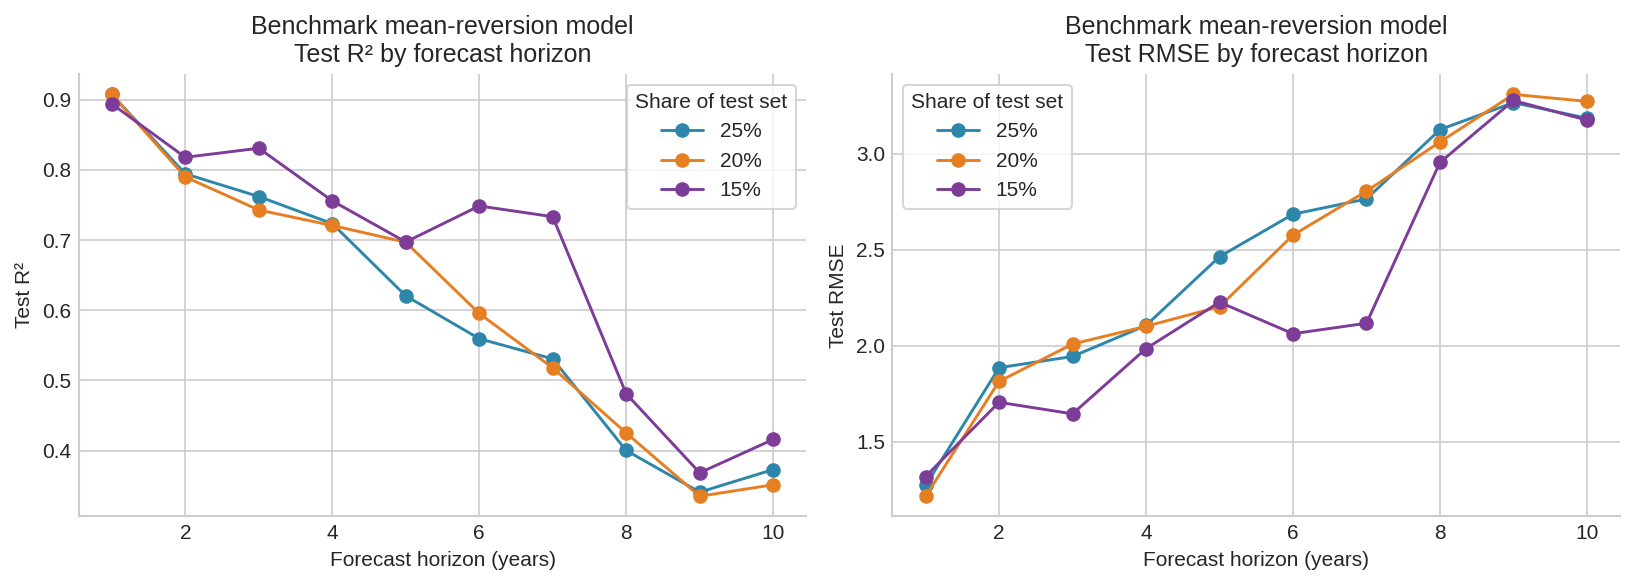

In [5]:
# compare performance across splits for each model

import pandas as pd

df = pd.read_pickle("saved/df.dat")

from functions.summary import plot_model_splits

plot_model_splits("benchmark", title_text="Benchmark mean-reversion model", df=df)

The benchmark mean‑reversion model shows strong short‑term persistence, with test R² values close to 0.9 for one‑year‑ahead spreads. Predictive power declines steadily with the forecast horizon, reaching around 0.4–0.5 by year 8–10, while RMSE rises from roughly 1.3 p.p. to around 3.0 p.p. over the same period.

Across test splits, results are broadly consistent but not identical. The 85‑15 split tends to retain slightly higher R² at intermediate horizons, while the 25% test split shows a smoother decline. These mild discrepancies suggest that the strength of mean‑reversion and persistence varies somewhat with sample composition and the balance between high‑ and low‑volatility periods.

Overall, the temporal pattern points to a slow yet measurable erosion of spread predictability over time: near‑term dynamics are dominated by persistence, while longer horizons increasingly reflect structural differences and accumulated shocks that are harder to forecast.

---------------------------------------------------------------------------------------------------------------------------------------
                                     75-25 TRAIN-TEST SET SPLIT                                     
---------------------------------------------------------------------------------------------------------------------------------------

>>> RIDGE
---------------------------------------------------------------------------------------------------------------------------------------
 horizon R²_test RMSE_test ΔR² vs Benchmark (p.p.) ΔRMSE vs Benchmark (bps) H1=Non-equal predictive accuracy (DM test) DM_stat  DM_p
       1  0.9085    1.2651                   +0.11                     -0.8                                   Rejected    1.03 0.303
       2  0.7969    1.8737                   +0.26                     -1.2                                   Rejected    1.32 0.186
       3  0.7670    1.9231                   +0.51                     -2.1      

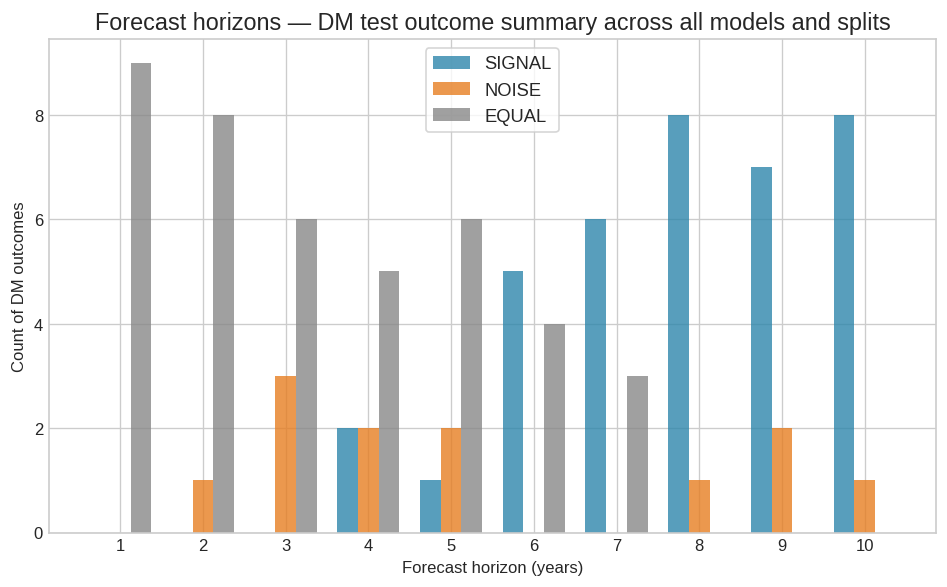

In [6]:
# incremental signal regressions across 1 to 10 year horizon

from functions.summary import get_benchmark_stats, print_temporal_signal_stats, plot_temporal_signal_summary

import pandas as pd

df = pd.read_pickle("saved/df.dat")

benchmark_df_75 = get_benchmark_stats(df, 0.75)
benchmark_df_80 = get_benchmark_stats(df, 0.80)
benchmark_df_85 = get_benchmark_stats(df, 0.85)

benchmark_dfs = {
    0.75: benchmark_df_75,
    0.80: benchmark_df_80,
    0.85: benchmark_df_85
}

print_temporal_signal_stats(
    specs_dir="specs",
    base_name="signal",
    models=["ridge", "lasso", "elastic"],
    benchmark_dfs=benchmark_dfs
)

plot_temporal_signal_summary(
    specs_dir="specs",
    base_name="signal",
    models=["lasso", "ridge", "elastic"],
    benchmark_dfs=benchmark_dfs
)

Across forecast horizons, the Diebold‑Mariano outcomes confirm three distinct predictive regimes. For short horizons (1–2 years), nearly all models fall into the equal‑accuracy category: incremental regressions track the mean‑reversion benchmark almost perfectly, with no additional predictive signal. At these horizons, spreads are dominated by persistence, and model complexity adds noise rather than insight.

At intermediate horizons (3–5 years), results become mixed: noise outcomes rise as models begin to deviate from mean reversion without yielding consistent forecast improvements. This stage reflects transitional dynamics — diminishing autocorrelation from the benchmark, but insufficient long‑term signal yet emerging from the fundamentals.

From six years onward, a more systematic signal appears. Predictive accuracy improves across regularised models, with the a strong concentration of signal at year 7 to 10, with year 9 showing a partial reversion toward noise. This alternating pattern suggests that fundamentals gradually gain explanatory strength over longer horizons, though the power is uneven and interacts with sample composition and horizon‑specific volatility. In summary, short‑term forecasts are persistence‑driven, the mid‑range is noisy and unstable, and long‑horizon models capture genuine but horizon‑sensitive structural signal.

In [7]:
# which variables provide incremental signal?

from functions.summary import summarise_temporal_signal_vars
from functions.labels import all_labels

summarise_temporal_signal_vars(
    specs_dir="specs",
    base_name="signal",
    models=["ridge", "lasso", "elastic"],
    all_labels=all_labels
)

AVERAGE SHAP IMPORTANCE BY MODEL FOR T4 (%)
                                            Label  Average Lasso (–)  Ridge (75/25)  Elastic Net (L1=0.5) (75/25)
   4D(iii). Freedom of Foreigners to Visit (0–10)    22.92         -          45.83                          0.00
                         Monetary Freedom (0–100)    15.65         -           2.21                         29.09
      Real GDP Growth (annual %, constant prices)    13.88         -           1.95                         25.81
                        Inflation (CPI, annual %)     7.33         -           0.28                         14.38
               Current Account Balance (% of GDP)     6.99         -           0.95                         13.03
         2C. Protection of Property Rights (0–10)     5.46         -           0.84                         10.07
       3B. Standard Deviation of Inflation (0–10)     2.33         -           1.00                          3.65
Social Progress Index – Basic Human Needs (0

The SHAP decomposition across horizons (T4–T10) shows a clear transition in what markets price as key sovereign risk drivers. At medium horizons (T4–T5), Freedom of Foreigners to Visit and Monetary Freedom dominate, together accounting for 30–40% of total importance. These variables capture institutional openness and policy credibility — signalling that, a few years out, markets still reward countries that maintain macro discipline and institutional accessibility. The prominence of Real GDP Growth and Protection of Property Rights at these horizons further supports a forward‑looking but still policy‑anchored pricing logic.

Beyond five years, the structure shifts markedly toward monetary credibility channels. Inflation becomes the single most important driver, with SHAP contributions exceeding 50% in several horizons (T6–T7, T10), while the GDP Deflator emerges as a complementary indicator of general price‑level credibility. The persistence of these two variables suggests that what ultimately sustains creditworthiness in the long run is the capacity to preserve internal nominal stability.

Meanwhile, the earlier leaders — Freedom of Foreigners to Visit and Monetary Freedom — decline in importance as horizons lengthen, indicating that openness and formal monetary frameworks gradually give way to deeper, outcome‑based measures of credibility. In other words, the market’s pricing focus evolves from institutional access and policy reputation to sustained performance on inflation and monetary stability — a shift from structural signalling to proven long‑term consistency in macro management.

### Appendix: Structural persistence of priced-in fundamentals

This section examines how the relationship between fundamentals and sovereign spreads evolves over time by regressing future spread levels (1 to 10 years into the future) on current macroeconomic and institutional variables.

A slow decay in explanatory power indicates that spreads remain anchored in long‑lived structural traits consistently priced by markets, while a faster decay or shifting variable mix reflects an adaptive pricing structure in which the weight of fundamentals changes over time.

In [8]:
# priced-in regressions across splits

from functions.summary import print_temporal_stats, get_prediction_stats, get_benchmark_stats

import pandas as pd

df = pd.read_pickle("saved/df.dat")

specs_dir = "specs"
base_name = "levels"
suffix = ""

summary_df_75 = get_prediction_stats(specs_dir, base_name, suffix, 0.75)
summary_df_80 = get_prediction_stats(specs_dir, base_name, suffix, 0.80)
summary_df_85 = get_prediction_stats(specs_dir, base_name, suffix, 0.85)

benchmark_df_75 = get_benchmark_stats(df, 0.75)
benchmark_df_80 = get_benchmark_stats(df, 0.80)
benchmark_df_85 = get_benchmark_stats(df, 0.85)

print("75-25 TRAIN-TEST SET SPLIT")
print("-"*125)
print_temporal_stats(summary_df_75, benchmark_df_75)
print("80-20 TRAIN-TEST SET SPLIT")
print("-"*125)
print_temporal_stats(summary_df_80, benchmark_df_80)
print("85-15 TRAIN-TEST SET SPLIT")
print("-"*125)
print_temporal_stats(summary_df_85, benchmark_df_85)

75-25 TRAIN-TEST SET SPLIT
-----------------------------------------------------------------------------------------------------------------------------
Test‑set R² by Horizon                                         Test‑set RMSE by Horizon
-----------------------------------------------------------------------------------------------------------------------------
model    elastic net L1=0.5  lasso ridge  mean reversion       model    elastic net L1=0.5  lasso ridge  mean reversion
horizon                                                        horizon                                                 
1                     0.498  0.535 0.511           0.907       1                     2.969  2.857 2.932           1.273
2                     0.266  0.382 0.373           0.794       2                     3.589  3.295 3.318           1.886
3                     0.290  0.225 0.274           0.762       3                     3.395  3.547 3.434           1.944
4                     0.349  0.34

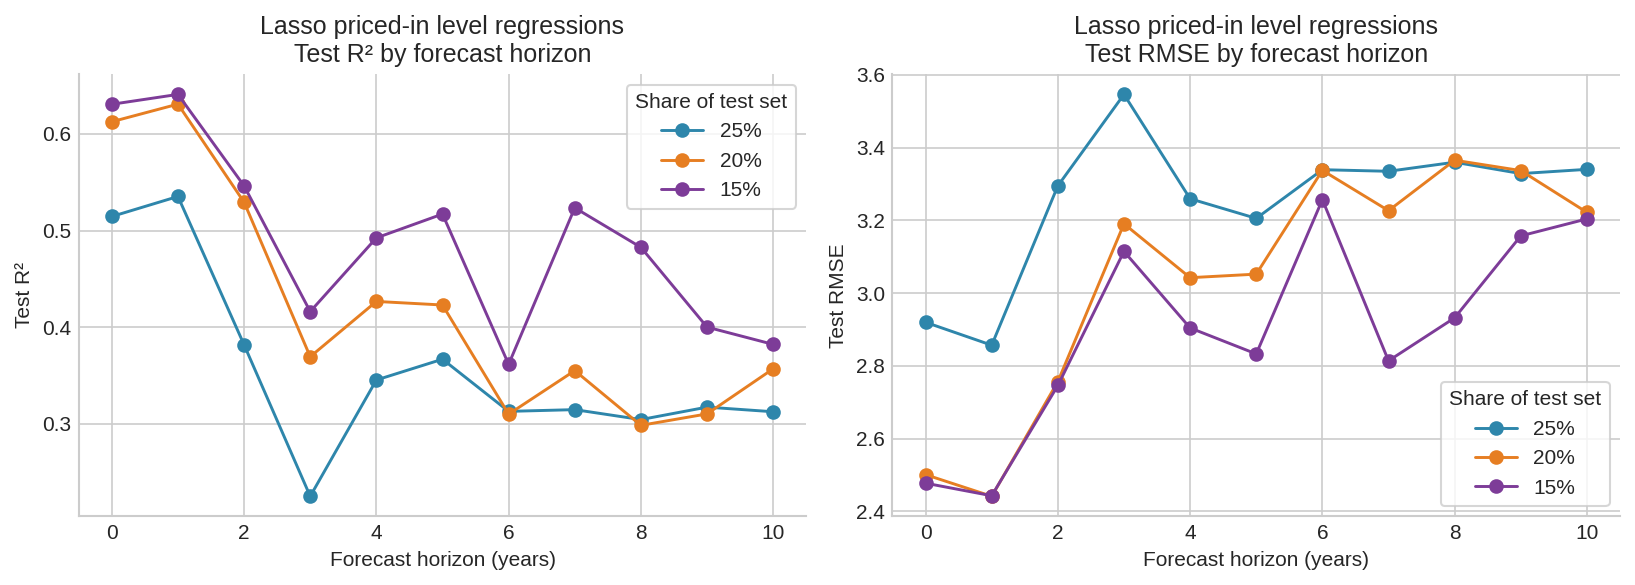

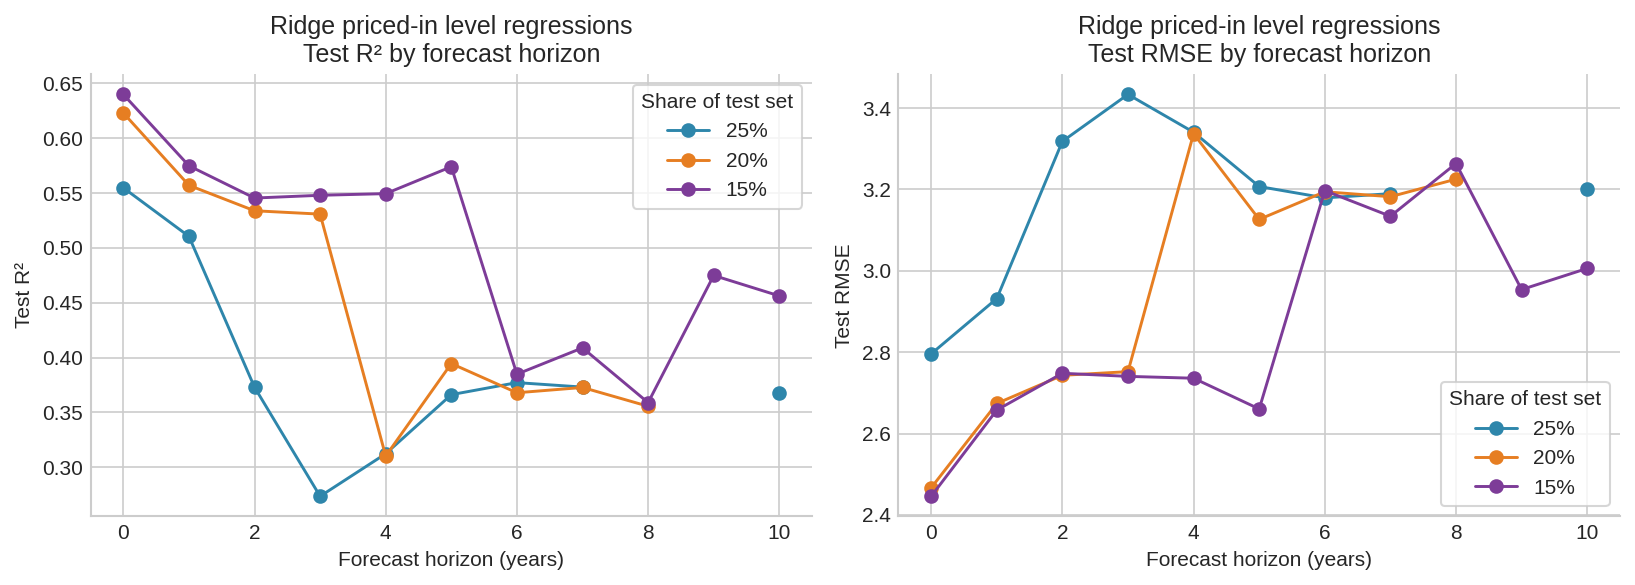

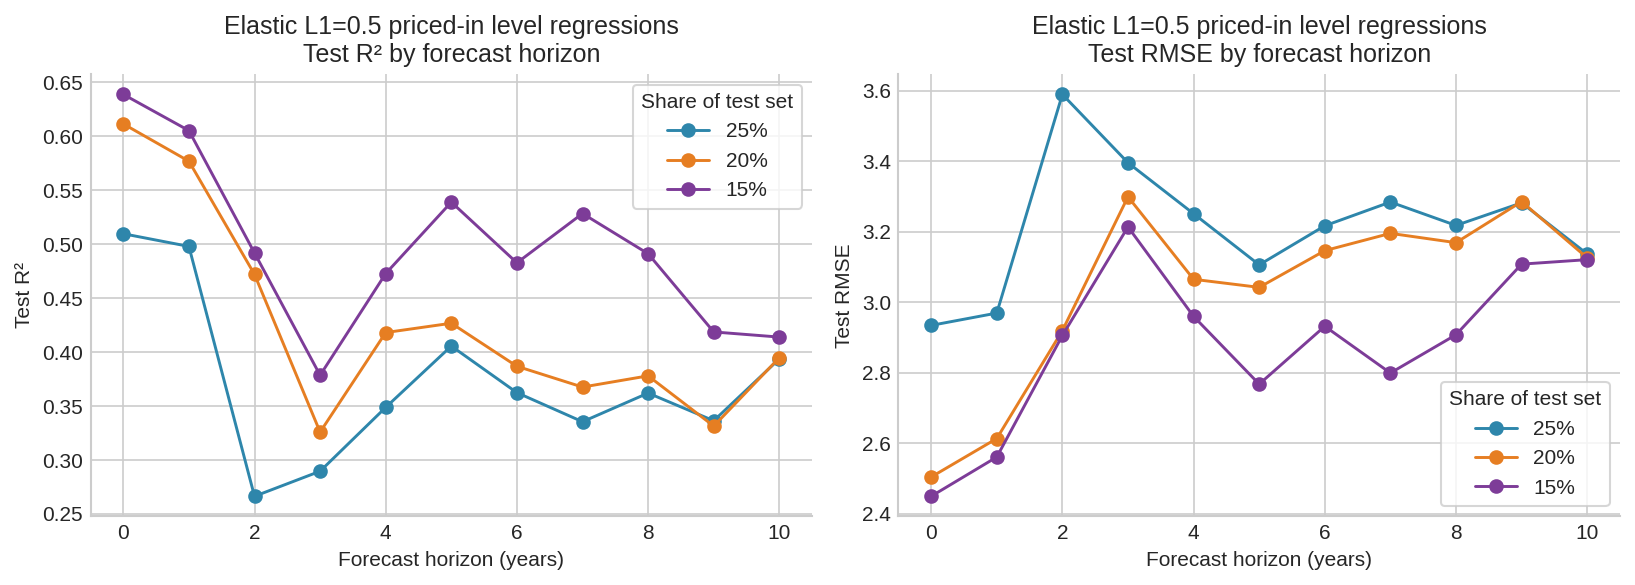

In [9]:
# plot performance across splits

import pandas as pd

df = pd.read_pickle("saved/df.dat")

from functions.summary import plot_model_splits

plot_model_splits("lasso_levels", "Lasso priced-in level regressions")
plot_model_splits("ridge_levels", "Ridge priced-in level regressions")
plot_model_splits("elastic_levels", "Elastic L1=0.5 priced-in level regressions")

In [10]:
# check variable importance per horizon h regression

from functions.labels import all_labels
from functions.summary import summarise_priced_in_regressions

horizon = 5

model_configs = [
    ("lasso", None),
    ("ridge", None),
    ("elastic", 0.25),
    ("elastic", 0.5),
    ("elastic", 0.75)
]

summarise_priced_in_regressions(
    specs_dir="specs",
    base_name="levels",
    suffix="",
    model_configs=model_configs,
    all_labels=all_labels,
    h=horizon
)

PRICED‑IN LEVEL REGRESSIONS — PERFORMANCE SUMMARY
 Horizon Split                Model  R²_train  R²_test  RMSE_test
       5 75‑25 Elastic Net (L1=0.5)    0.2183   0.4056     3.1058
       5 75‑25                Lasso    0.1902   0.3668     3.2056
       5 75‑25                Ridge    0.1357   0.3662     3.2072
       5 80‑20 Elastic Net (L1=0.5)    0.2206   0.4268     3.0420
       5 80‑20                Lasso    0.2736   0.4230     3.0522
       5 80‑20                Ridge    0.1412   0.3946     3.1264
       5 85‑15 Elastic Net (L1=0.5)    0.2748   0.5391     2.7676
       5 85‑15                Lasso    0.2281   0.5171     2.8328
       5 85‑15                Ridge    0.2461   0.5741     2.6604

* denotes variables selected in >80% of regressions (stability selection not performed for Ridge)

LASSO — SHAP IMPORTANCE BY TRAIN‑TEST SPLIT (%)
                                                              label  Average  75‑25  80‑20  85‑15
                                   2A. Judic

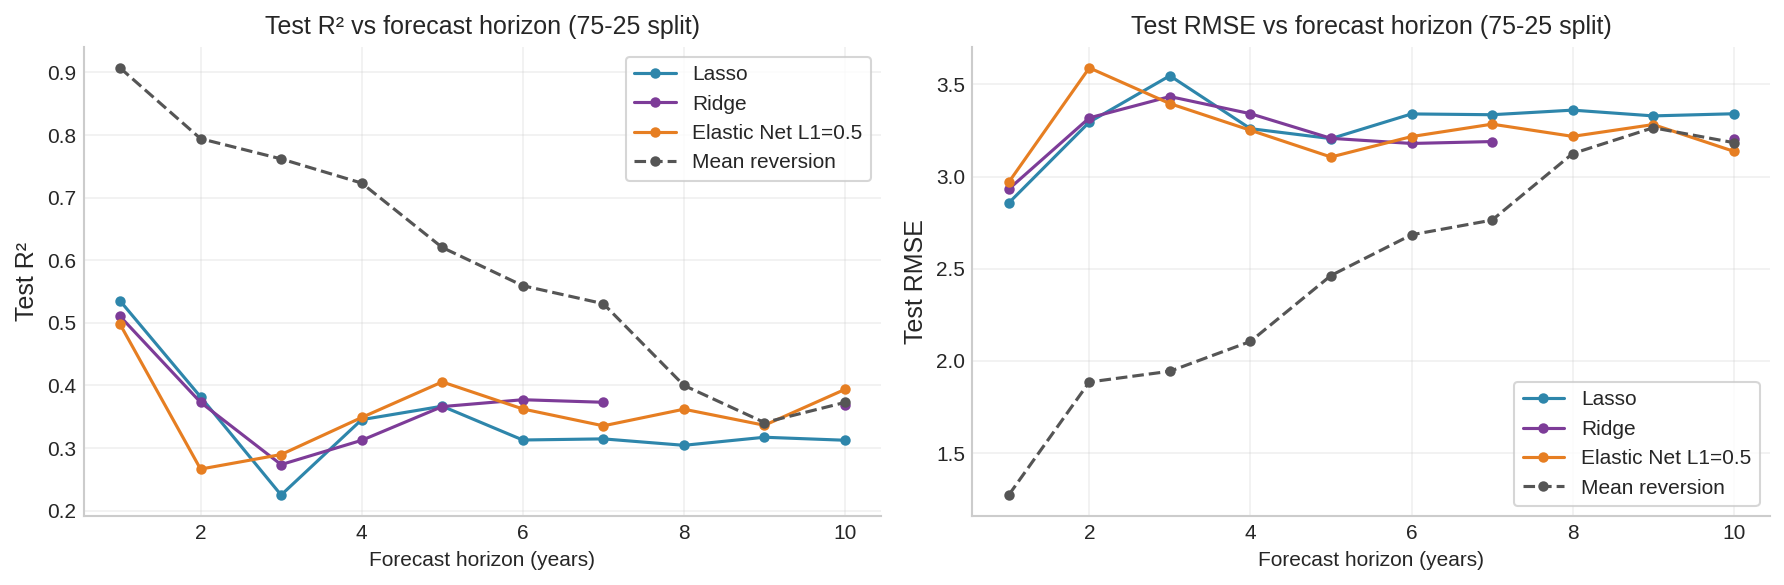

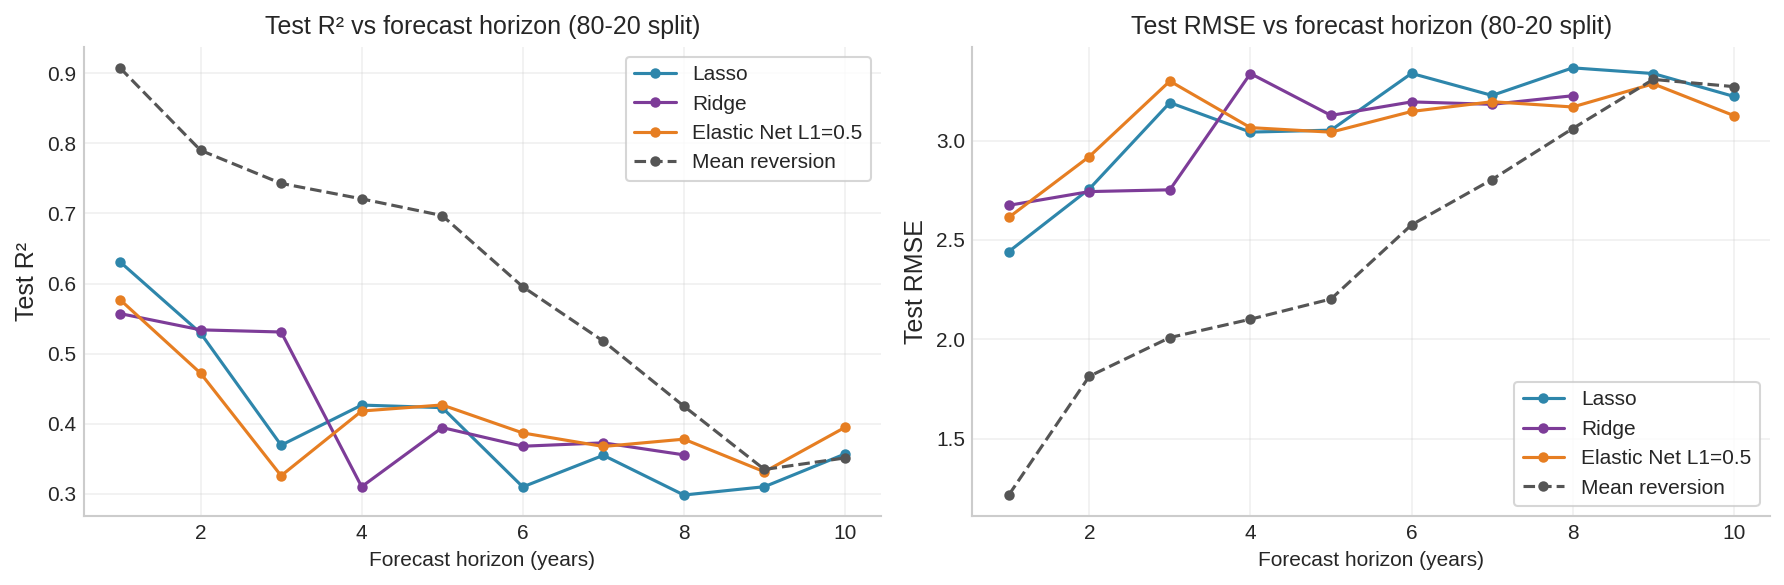

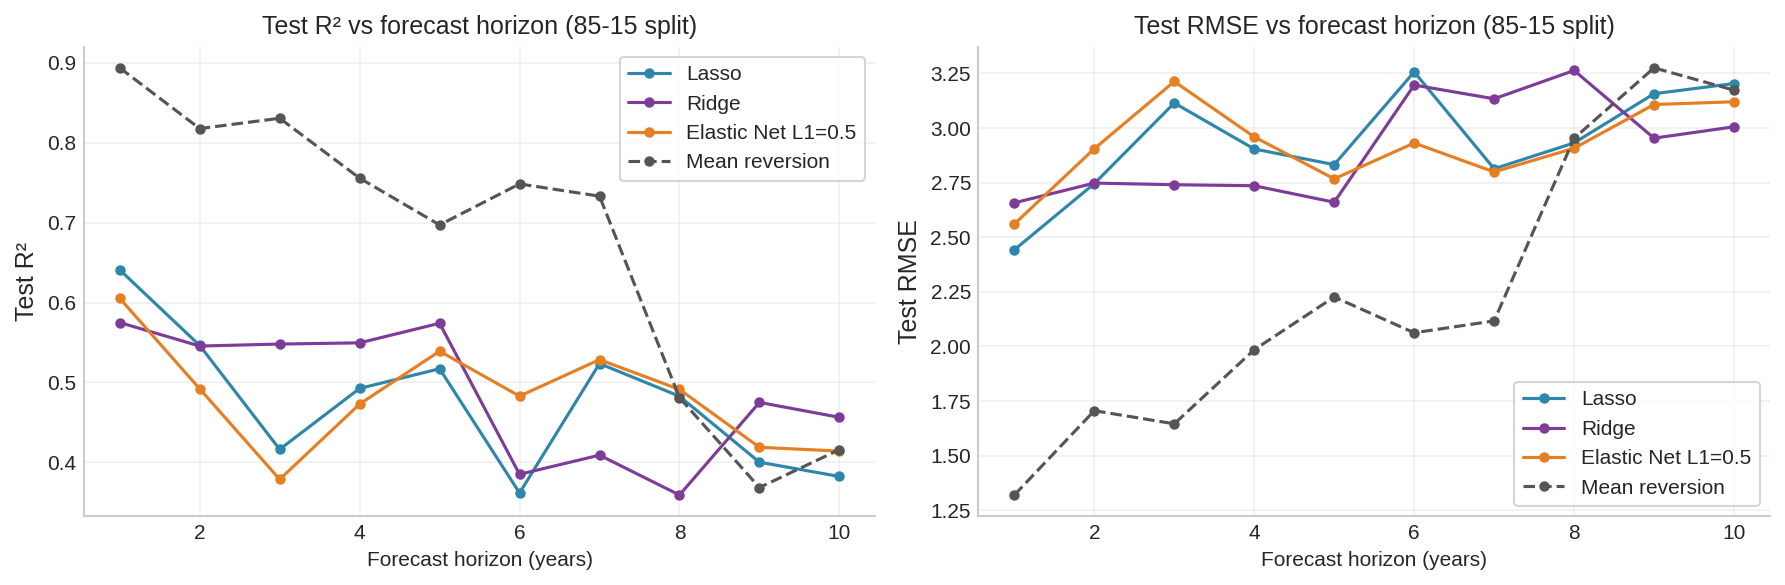

In [11]:
# compare with benchmark across splits

from functions.summary import get_prediction_stats, get_benchmark_stats, plot_temporal_stats

plot_temporal_stats(summary_df_75, benchmark_df_75, 0.75)
plot_temporal_stats(summary_df_80, benchmark_df_80, 0.8)
plot_temporal_stats(summary_df_85, benchmark_df_85, 0.85)

In [ ]:
# convert notebook to HTML / update HTML

import subprocess, shutil, os

notebook_name = "05_summary.ipynb"
output_html = "05_summary.html"
output_dir = "docs"

subprocess.run(["jupyter", "nbconvert", "--to", "html", notebook_name], check=True)
os.makedirs(output_dir, exist_ok=True)
src = output_html
dst = os.path.join(output_dir, output_html)
shutil.move(src, dst)

print(f"Updated {dst}")